In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data2.csv')
df.dropna(subset=['price'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
features = list(df.columns)
target = 'price'
features.remove(target)

X = df[features]
y = df[target].str.strip("$").str.replace(",","").astype(float)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
class Data_Transformer(object):
    
    def fit(self, X, y=None):
        new_df = pd.DataFrame()
        new_df["Weight"] = X["weight"].map(self.weight2num) # convert weight to numerical value
        self.mean_weight = new_df["Weight"].mean() # obtain mean weight
        new_df["Weight"].fillna(self.mean_weight,inplace=True) # fill in missing weight with mean weight
        new_df["Month"] = pd.to_datetime(X["purchase_date"]).dt.month # convert purchase date to purchase weekday
        self.majority_month = new_df["Month"].mode()[0] # obtain majority purchase month
        new_df["Month"].fillna(self.majority_month,inplace=True) # fill in missing purchase month with majority purchase month
        new_df["Weekday"] = pd.to_datetime(X["purchase_date"]).dt.weekday # convert purchase date to purchase weekday
        self.majority_weekday = new_df["Weekday"].mode()[0] # obtain majority purchase weekday
        new_df["Weekday"].fillna(self.majority_weekday,inplace=True) # fill in missing purchase weekday with majority purchase weekday
        new_df["Ingredient Number"] = X["ingredient"].map(self.get_numbers) # obtain number of ingredients in recipe
        self.mean_ingredient_number = new_df["Ingredient Number"].mean() # obtain mean ingredient number
        new_df['Ingredient Number'].fillna(self.mean_ingredient_number,inplace=True) # fill in missing ingredient number with median ingredient number
        self.pl_le = LabelEncoder() # create label-encoder
        new_df["Product Level"] = pd.Series(self.pl_le.fit_transform(X["product_level"])) # fit and transform product level with label-encoder
        self.majority_product_level = new_df["Product Level"].mode()[0] # obtain majority product level code
        new_df["Product Level"].fillna(self.majority_product_level,inplace=True) # fill in missing product level with majority product level code
        self.pt_le = LabelEncoder() # create label-encoder
        new_df["Product Type"] = pd.Series(self.pt_le.fit_transform(X["product_type"])) # fit and transform product type with label-encoder
        self.majority_product_type = new_df["Product Type"].mode()[0] # obtain majority product type code
        new_df["Product Type"].fillna(self.majority_product_type,inplace=True) # fill in missing product type with majority product type code
        new_df["Cost"] = X["cost"].str.strip("$").str.strip("k").astype(float)*1000 # convert cost to numerical value
        self.cost_imputer = XGBRegressor() # create a XGBoost imputer for cost
        df_for_imputing_cost = new_df.dropna() # create training data for cost imputer by dropping missing data
        self.cost_imputer.fit(df_for_imputing_cost[["Weight","Month","Weekday","Ingredient Number","Product Level","Product Type"]], df_for_imputing_cost["Cost"]) # fit cost imputer
        
    def transform(self, X, y=None):
        new_df = pd.DataFrame()
        new_df["Weight"] = X["weight"].map(self.weight2num) # convert weight to numerical value
        new_df["Weight"].fillna(self.mean_weight,inplace=True) # fill in missing weight with mean weight
        new_df["Month"] = pd.to_datetime(X["purchase_date"]).dt.month # convert purchase date to purchase month
        new_df["Month"].fillna(self.majority_month,inplace=True) # fill in missing purchase month with majority purchase month
        new_df["Weekday"] = pd.to_datetime(X["purchase_date"]).dt.weekday # convert purchase date to purchase weekday
        new_df["Weekday"].fillna(self.majority_weekday,inplace=True) # fill in missing purchase weekday with majority purchase weekday
        new_df['Ingredient Number'] = X["ingredient"].map(self.get_numbers) # obtain number of ingredients in recipe
        new_df['Ingredient Number'].fillna(self.mean_ingredient_number,inplace=True) # fill in missing ingredient number with mean ingredient number
        new_df["Product Level"] = self.pl_le.transform(X["product_level"]) # transform product level with label-encoder
        new_df["Product Level"].fillna(self.majority_product_level,inplace=True) # fill in missing product level with majority product level code
        new_df["Product Type"] = self.pt_le.transform(X["product_type"]) # transform product type with label-encoder
        new_df["Product Type"].fillna(self.majority_product_type,inplace=True) # fill in missing product type with majority product type code
        new_df["Cost"] = X["cost"].str.strip("$").str.strip("k").astype(float)*1000 # convert cost to numerical value
        imputed_cost = pd.Series(self.cost_imputer.predict(new_df[new_df["Cost"].isnull()][["Weight","Month","Weekday","Ingredient Number","Product Level","Product Type"]])) # obtain imputed cost
        imputed_cost.index = new_df[new_df["Cost"].isnull()]["Cost"].index # set index of imputed cost
        new_df["Cost"].fillna(imputed_cost,inplace=True) # fill in missing cost with imputed cost
        return new_df # return new_df
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def weight2num(self, x): # function to convert weight to number
        if type(x) == str:
            x = x.strip('Kg').split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
        
    def get_numbers(self, x): # function to get number of ingredients in recipe
        if type(x) == str:
            return len(x.split(','))
        else:
            return x

In [6]:
dft = Data_Transformer()
X_train = np.array(dft.fit_transform(X_train))
X_test = np.array(dft.transform(X_test))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
import time
import torch
from torch import nn
from torch.nn import MSELoss

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = nn.Sequential(nn.Linear(7, 64),
                    nn.ReLU(),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Linear(32, 1)).to(device)

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

batch_size = 500
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [10]:
loss = MSELoss(reduction='mean')
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [11]:
epochs = 1000
train_losses = []
test_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device).view(-1, 1)
        output = net(data)
        L = loss(output, target)
        L.backward()
        optimizer.step()
    
    y_train_pred = net(X_train)
    training_loss = loss(y_train_pred, y_train.view(-1, 1)).item()
    y_test_pred = net(X_test)
    test_loss = loss(y_test_pred, y_test.view(-1, 1)).item()
    
    train_losses.append(training_loss)
    test_losses.append(test_loss)
    
    end = time.time()
    print("Epoch {}: Train_loss {}, Validation_loss {}, Seconds {}".format(epoch, training_loss, test_loss, end-start))

Epoch 0: Train_loss 77560274944.0, Validation_loss 79471566848.0, Seconds 0.031000375747680664
Epoch 1: Train_loss 73004261376.0, Validation_loss 74446602240.0, Seconds 0.02299976348876953
Epoch 2: Train_loss 67429691392.0, Validation_loss 68305014784.0, Seconds 0.020002365112304688
Epoch 3: Train_loss 60373929984.0, Validation_loss 60544319488.0, Seconds 0.10002374649047852
Epoch 4: Train_loss 51825283072.0, Validation_loss 51164545024.0, Seconds 0.0220034122467041
Epoch 5: Train_loss 42614366208.0, Validation_loss 41109454848.0, Seconds 0.023000717163085938
Epoch 6: Train_loss 35103309824.0, Validation_loss 33018689536.0, Seconds 0.019999980926513672
Epoch 7: Train_loss 32265117696.0, Validation_loss 30167531520.0, Seconds 0.025005102157592773
Epoch 8: Train_loss 33121460224.0, Validation_loss 31321493504.0, Seconds 0.02402782440185547
Epoch 9: Train_loss 32896624640.0, Validation_loss 31043618816.0, Seconds 0.02199864387512207
Epoch 10: Train_loss 32283432960.0, Validation_loss 3023

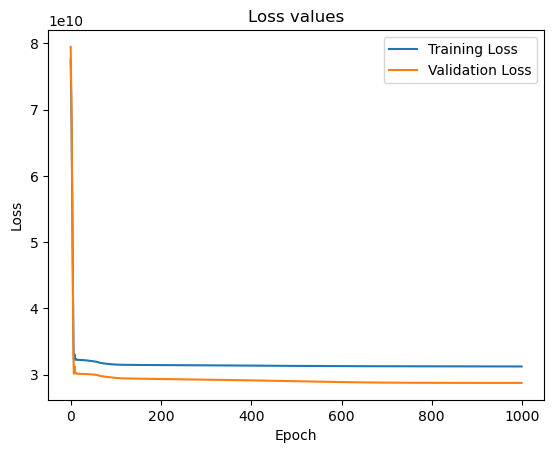

In [12]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [13]:
y_train_pred = net(X_train)
y_test_pred = net(X_test)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred.detach().numpy())))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred.detach().numpy())))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred.detach().numpy())))

train MAE: 1.10e+05
train MSE: 3.13e+10
train R2: 0.353


In [16]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred.detach().numpy())))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred.detach().numpy())))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred.detach().numpy())))

test MAE: 1.12e+05
test MSE: 2.88e+10
test R2: 0.424
